Game player
---

In [3]:
import tensorflow as tf
import keras
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('dark_background')
# import connect4

Game board, players classes

In [200]:
class GameBoard:
    def __init__(self, board_shape = (6,7), verbose = True):
        self.verbose = verbose
        self.shape = board_shape
        self.grid = np.full(board_shape, 0, ).astype('float32')
        black = (0.2,0.2,0.2)
        red = (0.9, 0.3,0.3)
        blue = (0.3,0.3,0.9)
        self.colors = {
            0:black,
            1:red,
            -1:blue
        }
        
    #drop the specified element into the specified column, and return True. Returns False if the column is full and makes no changes.
    def drop(self, color, column):
        #check if the column is full first
        if self.grid[0,column] != 0:
            if self.verbose:
                print(f'Cannot drop a {color} in full column {column}!')
            return False
        else:
            dropping = True
            current_row = 0
            
            #drop the color until the spot below is filled
            while dropping:
                #if it hits the bottom, stop falling
                if current_row == self.shape[0]-1:
                    dropping = False
                #if the next row is empty, drop to it
                elif self.grid[current_row + 1, column] == 0:
                    current_row += 1
                else:
                    dropping = False
                    
            #assign the color to the spot in the grid
            self.grid[current_row, column] = color
            return True
    
    #converts the grid to plottable colors
    def grid_to_color(self, color_dict_in = None):
        if color_dict_in == None:
            color_dict = self.colors
        else:
            color_dict = color_dict_in
        color_grid = self.grid
        color_grid = [
            [
                color_dict[value]
                for value in row
            ]
            for row in color_grid
        ]
        color_grid = np.array(color_grid)
        return color_grid
    
    #shows the grid with plt.imshow
    def show(self, figsize = (6,7), colors = None):
#         if colors == None:
#             color_dict
        fig, ax = plt.subplots(figsize = figsize)
        grid_pic = self.grid_to_color()
        plt.imshow(grid_pic)
#         ax.set_xticks(np.arange(-.5, 7, 1))
#         ax.set_yticks(np.arange(-.5, 6, 1))
        plt.grid(True)
        plt.xticks(np.arange(-.5, 7, 1), labels = range(1,9))
        plt.yticks(np.arange(-.5, 6, 1), labels = [])



class ConnectFour(GameBoard):
    def __init__(self, starting_player = 1, second_player = -1, board_shape = (6,7), verbose = True):
        super().__init__(board_shape, verbose)
        self.verbose = verbose
        self.current_player = 0
        self.players = [starting_player, second_player]
        self.turns = 0
        self.winning_turn = 0
        self.winner = None
        self.done = False
        self.last_play = None
        self.history = []
        self.scores = [0,0] #scores for player 0 and player 1
        
    def reset(self):
        self.grid = np.full(self.shape, 0)
        self.turns = 0
        self.winner = None
        self.done = False
          
    #checks a single row
    def four_in_row(self, row):
        for window in range(self.shape[1]-3):
            if abs(self.grid[row, window:window+4].sum()) == 4:
                return True
        return False
    
    #checks a single column
    def four_in_col(self, col):
        for window in range(self.shape[0]-3):
            if abs(self.grid[window:window+4, col].sum()) == 4:
                return True
        return False
        
    
    #scan major diagonals drawn from upper left across
    def four_in_diag(self, kth_diagonal, minor = False):
        #optionally mirror the array to check /-tilted diagonals
        if minor:
            this_diagonal = np.diag(np.fliplr(self.grid), kth_diagonal)
        else:
            this_diagonal = np.diag(self.grid, kth_diagonal)
        for window in range(len(this_diagonal)-3):
            if abs(this_diagonal[window:window+4].sum()) == 4:
                return True
        return False
    
    #drop the color of the current player and deal with the consequences
    def play(self, column, to_show = False):
        self.turns += 1
        drop_successful = self.drop(self.players[self.current_player], column)
        
        if drop_successful:
            self.last_play = [self.players[self.current_player], 'drop', column]
            ##check if state is win
            self.check_win()
            self.current_player = (self.current_player+1)%2
        else:
            self.last_play = [self.players[self.current_player], 'attempt', column]
        if to_show:
            self.show()
        self.history.append(self.last_play)
        return drop_successful
        
    #checks how many of 'value' are occupied in cells adjacent to grid[row,col]
    def count_adjacent(self, row, col, value):
        #check if center cell is on the edge of the grid
        top = row == 0
        bottom = row == self.grid.shape[0]-1
        left = col == 0
        right = col == self.grid.shape[1]-1
        
        #row indices
        upper_index = row - 1
        lower_index = row + 1
        if bottom:
            lower_index = row
        elif top:
            upper_index = row #or just upper_index == 0
        
        #column indices
        left_index = col - 1
        right_index = col + 1
        if left:
            left_index = col
        elif right:
            right_index = col
            
        #get slice
        gridslice = self.grid[upper_index:lower_index+1, left_index:right_index + 1]
        gridtruths = gridslice == value
        adjacent_count = gridtruths.sum() - (self.grid[row,col] == value) #subtract 1 to not count the center value, if it is the same
        return adjacent_count
        
        
        
    def play_series(self, moves:list = [1,2,3,4,5,6,6,6,5], to_show = False):
        for move in moves:
            self.play(move)
        if to_show:
            self.show()

    
    def check_win(self):
        if self.done and self.verbose:
            print(f'The game already ended with {self.winner} winning in {self.winning_turn} turns.')
        else:
            row_checks = [
                self.four_in_row(row)
                for row in range(self.shape[0])
            ]
            col_checks = [
                self.four_in_col(col)
                for col in range(self.shape[1])
            ]
            diag_count = max(self.shape)-3
            maj_diag_checks = [
                self.four_in_diag(k)
                for k in range(-diag_count, diag_count)
            ]
            min_diag_checks = [
                self.four_in_diag(k, minor = True)
                for k in range(-diag_count, diag_count)
            ]
            self.done = True in row_checks + col_checks + maj_diag_checks + min_diag_checks
            if self.done:
                self.winner = self.players[self.current_player]
                self.winning_turn = self.turns
                if self.verbose:
                    print(f'Player {self.winner} wins in {self.winning_turn} turns.')
        return self.done

Player classes

In [201]:
class Player:
    def __init__(self, name = 'Anders', num_actions = 7, random_seed = 2022):
        self.name = name
        self.num_actions = num_actions
        self.rng = np.random.default_rng(random_seed)
        
    def decide_random(self):
        decision = self.rng.choice(self.num_actions)
        return decision

# class C4Model(keras.models.Model):
#     def __init__(self, num_actions = 7, hidden_size = 1080)

class PlayerAC(Player):
    def __init__(self, name = 'Anders', num_actions = 7, hidden_size = 1080, random_seed = 2022):
        super().__init__(name, num_actions, random_seed)
        self.input_layer = tf.keras.Input(shape = (6,7), name = 'input layer')
        self.convolution_h = tf.keras.layers.Conv2D(8,
                                                    (1,4),
                                                    activation='relu',
                                                    input_shape = (6,7),
                                                    name = 'horizontal convolution',
                                                    padding = 'same'
                                                   )
        self.convolution_v = tf.keras.layers.Conv2D(2,
                                                    (5,1),
                                                    activation='relu',
                                                    input_shape = (6,7),
                                                    name = 'vertical convolution',
                                                    padding = 'same'
                                                   )
        self.convolution_square = tf.keras.layers.Conv2D(8,
                                                         (4,4),
                                                         activation='relu',
                                                         input_shape = (6,7),
                                                         name = 'square convolution',
                                                         padding = 'same'
                                                        )
        self.common1 = tf.keras.layers.Dense(hidden_size,
                                             activation = 'relu',
                                            name = 'common 1')
        self.actor = tf.keras.layers.Dense(num_actions,
                                    activation = 'softmax',
                                    name = 'actor'
                                 )
        self.critic = tf.keras.layers.Dense(1,
                                           activation = 'linear',
                                           name = 'critic')
        
        
    def simple_call(self, this_input):
        inputs = tf.expand_dims(this_input,0)
        x = self.common1(inputs)
        action_probs = self.actor(x)
        critic_value = self.critic(x)
        return tf.squeeze(action_probs), tf.squeeze(critic_value)
        
#give it a call
    def call(self, this_input, player_color):
        inputs = tf.expand_dims(this_input,3)
#         inx = self.input_layer(inputs)
        hx = self.convolution_h(inputs)
#         hx = tf.squeeze(hx)
        vx = self.convolution_v(inputs)
#         vx = tf.squeeze(vx)
        sqx = self.convolution_square(inputs)
#         sqx = tf.squeeze(sqx)
#         return hx, vx, sqx, tf.squeeze(inputs)
        x = keras.layers.concatenate([hx,vx,sqx,inputs])
        x = tf.reshape(x, shape=[1,-1])
        x = keras.layers.concatenate([x, tf.convert_to_tensor([[player_color]])])
        x = self.common1(x)
        actor_out, critic_out = tf.squeeze(self.actor(x)), tf.squeeze(self.critic(x))
        return actor_out, critic_out

In [202]:
c4 = ConnectFour()

In [118]:
c4.grid.astype('float32')

array([[0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [119]:
c4.count_adjacent(0,0,0)

3

In [80]:
c4.count_adjacent(1,3,0)

8

In [81]:
player = PlayerAC()

In [82]:
first_result = player.simple_call(tf.convert_to_tensor(c4.grid.reshape(6*7).astype('float32')))
first_result

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([0.14285715, 0.14285715, 0.14285715, 0.14285715, 0.14285715,
        0.14285715, 0.14285715], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.0>)

random game with two players
---

In [65]:
np.argmax(first_result[0])

0

Player -1 wins in 26 turns.


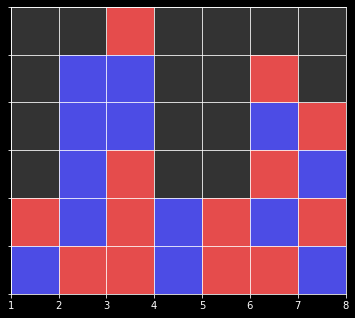

In [66]:
#pit two players against each other
player1 = Player(name='Bea', random_seed=202233)
player2 = Player(name='Chance', random_seed=2025341234542)
c4 = ConnectFour()

players = [player1, player2]
current_player = 0
board_changed = False
while not c4.done:
    board_changed = c4.play(players[current_player].decide_random())
    if board_changed:
        current_player = not current_player
        
        
c4.show()

Game with simple NN players
---

Cannot drop a -1 in full column 1!
Cannot drop a 1 in full column 1!
Player 1 wins in 29 turns.


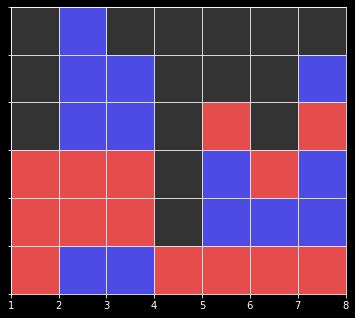

In [67]:
#pit two players against each other
player1 = PlayerAC(name='Bea', hidden_size=2048, random_seed=2022)
player2 = PlayerAC(name='Chance', hidden_size=1024, random_seed=2022)
c4 = ConnectFour()

rng_seed = 329454319

rng = np.random.default_rng(rng_seed)

players = [player1, player2]
current_player = 0
board_changed = False
while not c4.done:
    reshaped_grid = tf.convert_to_tensor(c4.grid.reshape(6*7).astype('float32'))
    result = players[current_player].simple_call(reshaped_grid)
    action_probs = tf.squeeze(result[0]).numpy()
    player_call = rng.choice(7, p=action_probs)
    board_changed = c4.play(player_call)
    if board_changed:
        current_player = not current_player
        
        
c4.show()

recursive training
---

In [203]:
player = PlayerAC()

In [204]:
player.call([c4.grid],1.)

(<tf.Tensor: shape=(7,), dtype=float32, numpy=
 array([0.1445294 , 0.13481751, 0.14632662, 0.14376153, 0.14245507,
        0.14606167, 0.14204822], dtype=float32)>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.017975368>)

In [205]:
#large reward to the winning move
reward_for_win = 50

#reward for each adjacent same color to new placement
reward_for_adjacent = 1

#penalty for attempting to place within a filled column
penalty_for_full = -1

In [206]:
rng_seed = 2022

In [207]:
num_games = 10

rng = np.random.default_rng(rng_seed)

# learning_rate = tf.optimizers.schedules.ExponentialDecay(0.01,100,0.1)
# optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

learning_rate = 0.01
optimizer = tf.optimizers.Adam(learning_rate = learning_rate)

huber = tf.losses.Huber()

#only for long term rewards.
gamma = 0.95

#create master player to play with itself
player = PlayerAC(hidden_size = 2048)

#play
for game in range(num_games):
    
    #set up rewards and results histories for a new game
    rewards = []
    actions = []
    critic_values = []
    action_probs = []
    
    #create new game
    c4 = ConnectFour(verbose=False)
    
    #keep track of the player for use in c4.players[...]
    # c4 also tracks it
    current_player = 0
    
    #play the game until it says its done.
    while not c4.done:
        # call the player
        player_color = tf.convert_to_tensor(c4.players[current_player], dtype='float32')
        action_probs, critic_value = player.call([c4.grid],player_color)
        action_probs = action_probs.numpy()
        player_call = rng.choice(7, p=action_probs)
        board_changed = c4.play(player_call)
        if board_changed:
            current_player = not current_player
        #record reward
        #record action
        #record critic value
    
    #add all rewards
    
    #convert rewards to losses
    
    #get total loss
    
    #calculate gradients
    
    #apply gradients
    